# GP Augmentation

## Modules Import

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import seaborn as sns

import sys

from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, make_scorer, f1_score, recall_score, precision_score
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_val_predict, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import cross_val_score

import copy
from sklearn.model_selection import StratifiedKFold

from sklearn.cluster import KMeans, DBSCAN
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split

from IPython.display import clear_output
from sklearn.metrics import silhouette_score, silhouette_samples
from matplotlib import cm

from utils import binarization, interpolation, rolling_diff, rolling_ratio, log10_, KFoldsClassifier

from scipy import stats

from IPython.display import Markdown, display

def printmd(string):
    display(Markdown(string))

In [2]:
import avocado

## Data Import

In [3]:
def type_mapping(claimedtype):
    return new_types.get(str(claimedtype).split(';')[0], 0)

def get_pval(row):
    pval = 1.0 - stats.chi2.cdf(row.rms_for_pval, row.size_r - 1)
    return pval

new_types = pd.read_csv('../data/types.csv')
new_types = dict(new_types.values)

data = pd.read_pickle('../data/new_article_data_r.pkl')
data['is_ia'] = data['type'].map(type_mapping)   
data['pval'] = data.apply(get_pval, axis=1)

In [4]:
data = data[~data.type.isna()].reset_index(drop=True)

In [5]:
data.shape

(3979, 9)

In [6]:
data[(data.spec_class == 1) & (data.is_ia == 1)].shape

(478, 9)

In [7]:
data.head()

,sn_name,type,size_r,curve_r,spec_class,rms,rms_for_pval,is_ia,pval
0,ASASSN-13ax,Dwarf Nova,122,"[[56477.4482, nan, 1.8373842952834476e-06, 7.4...",0,9186.448800,1.111560e+06,0,0.000000e+00
1,ASASSN-13cu,Ia,4,"[[56531.4793028785, nan, 1.9052852266272632e-0...",0,2674.142946,8.022429e+03,1,0.000000e+00
2,ASASSN-13dd,Ia,3,"[[56564.6063, nan, 1.982257181831107e-06, 1.46...",0,22.321894,4.464379e+01,1,2.021737e-10
3,ASASSN-13dl,Ia,28,"[[56577.0974, nan, 2.5262713683571743e-07, 6.7...",0,-1.000000,-1.000000e+00,1,1.000000e+00
4,ASASSN-14ae,TDE,45,"[[56684.1203, nan, 3.8508801287880484e-07, 8.2...",1,433.613743,1.907900e+04,0,0.000000e+00


In [8]:
from collections import Counter

c = Counter()

for elem in data.type:
    try:
        name = elem.split(';')[0]
        c[name] += 1
    except:
        continue

## Dataset Review

**Number of Samples**

In [9]:
data.shape[0]

3979

**Classes Distribution (0 - NOT_Ia, 1 - Ia)**

In [10]:
not_ia_share = data[data.is_ia == 0].shape[0] / data.shape[0]
ia_share = data[data.is_ia == 1].shape[0] / data.shape[0]

print("Not-Ia: {0:.2%}\nIa: {1:.2%}".format(not_ia_share, ia_share))

Not-Ia: 40.09%
Ia: 59.91%


## Sampling (RMS & P-value)

### P-Value CUTS

In [11]:
choices = np.zeros(shape=(10, 9))

for size_r in range(10):
    for i, pval in enumerate([0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.5, 0.9, 1]):
        n_samples = data[(data.pval <= pval) & (data.size_r >= size_r)].shape[0]
        choices[size_r, i] = n_samples

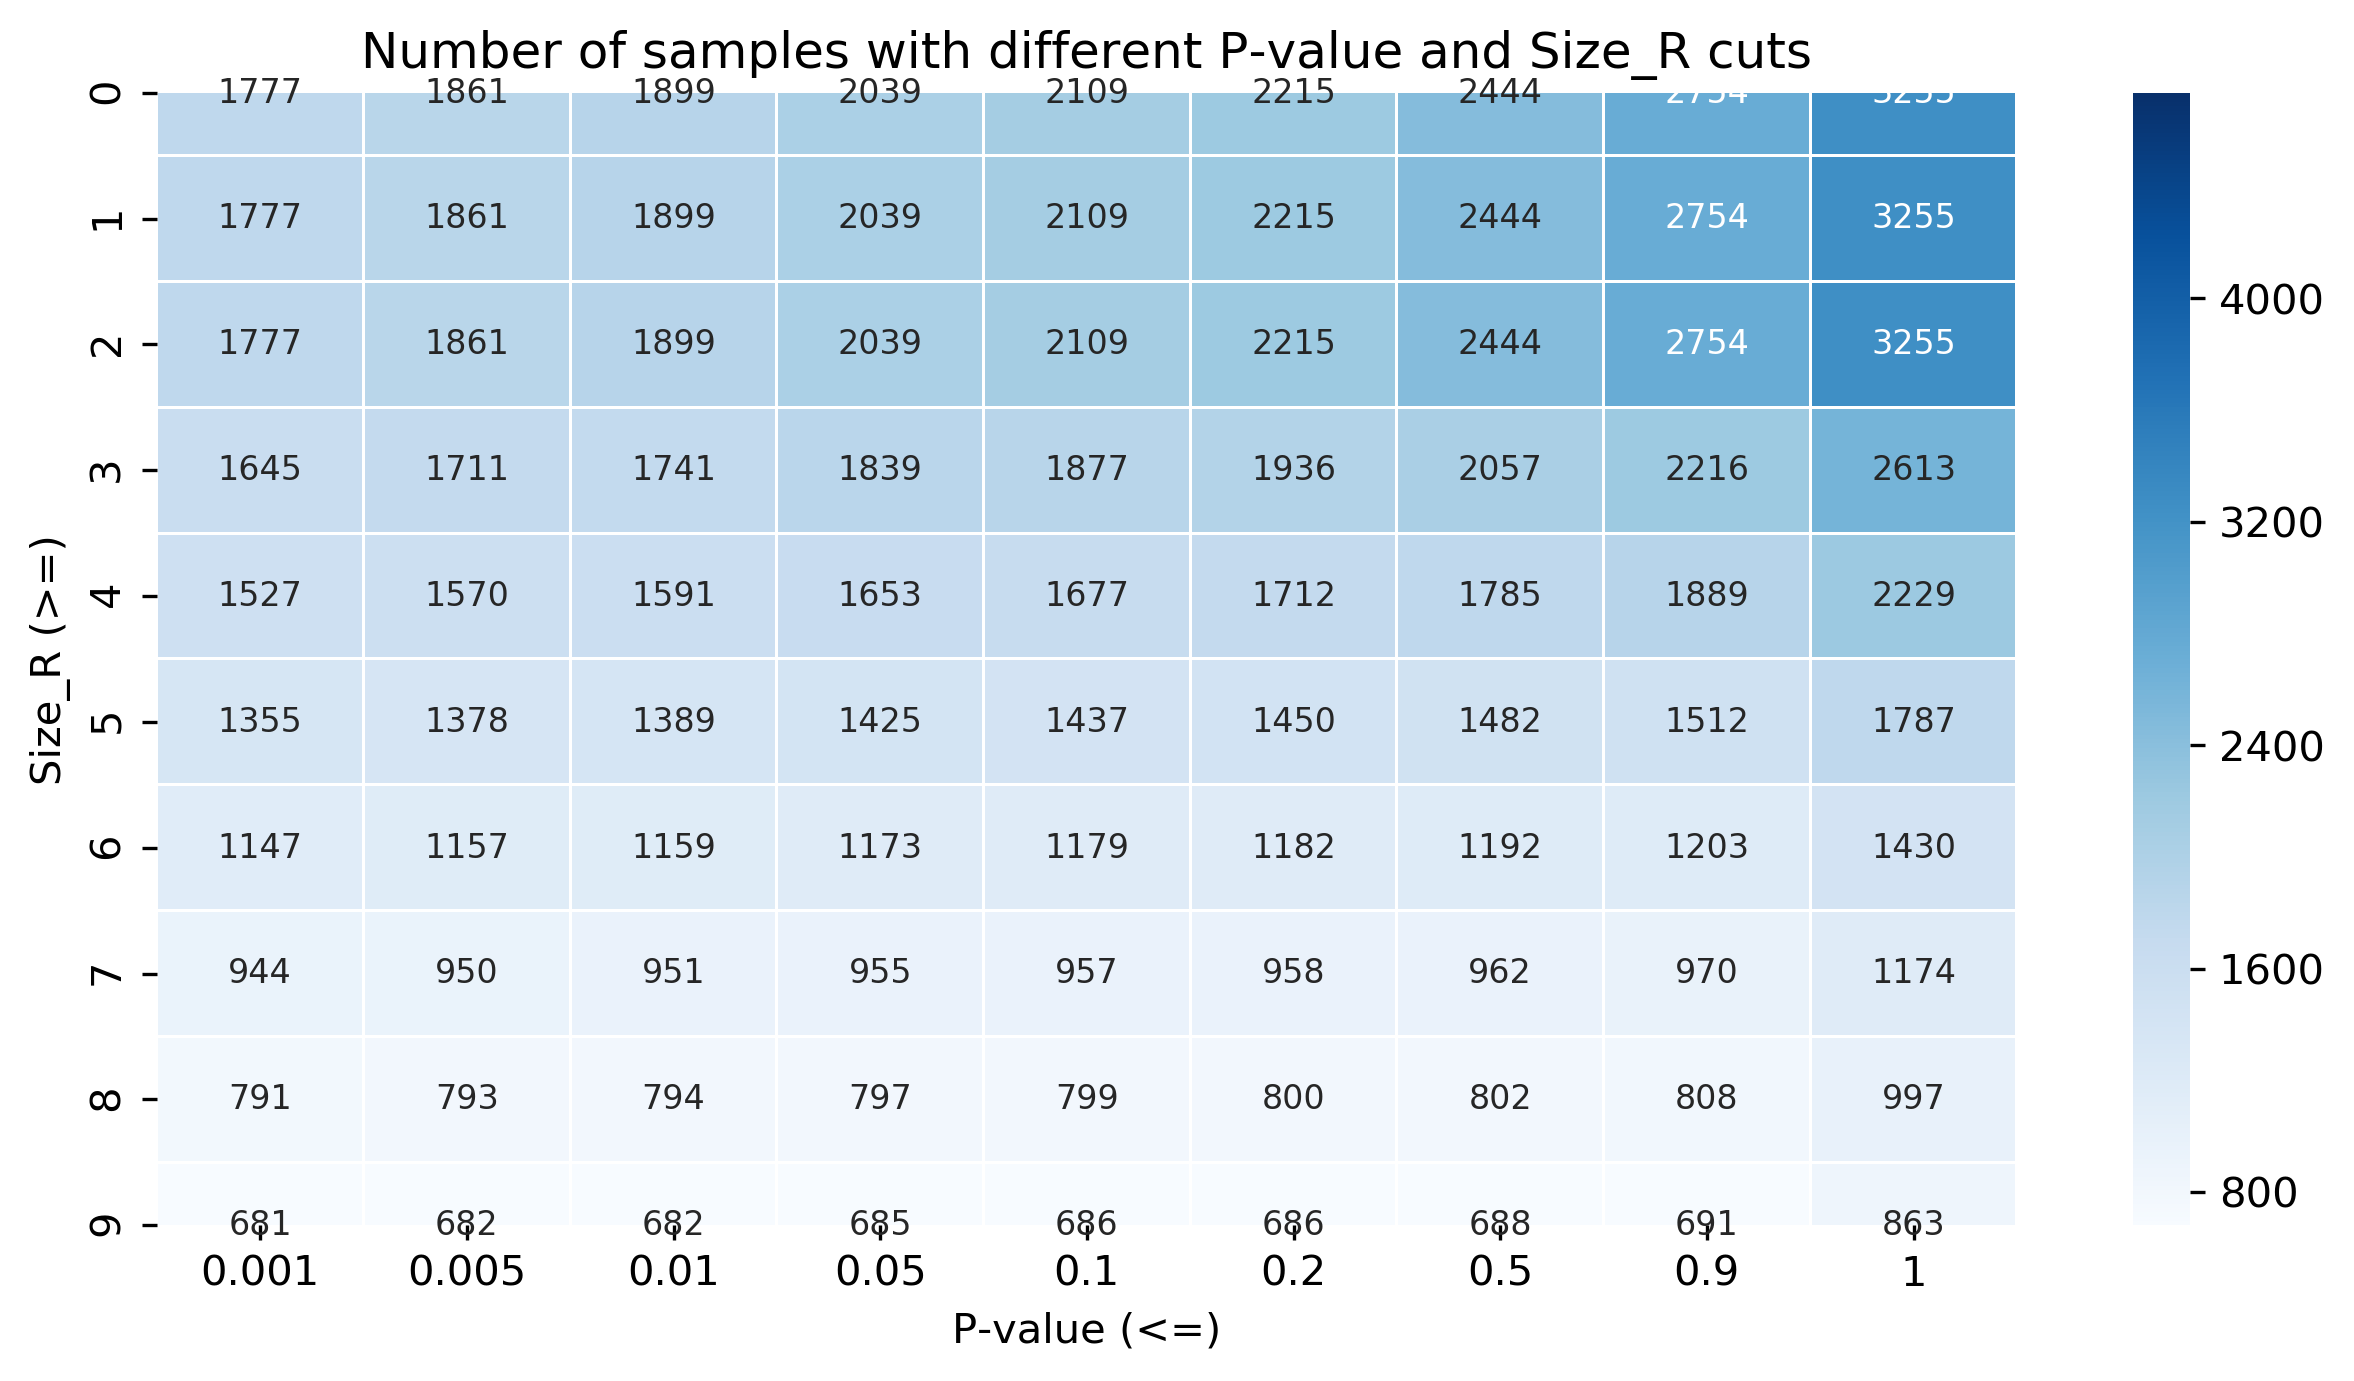

In [12]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 5), dpi=300)
sns.heatmap(choices, ax=ax, annot=True, fmt='.0f', linewidth=.5, cmap="Blues", 
            annot_kws={"size": 8}, vmax=4737,
            xticklabels=[0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.5, 0.9, 1],
            yticklabels=np.arange(10))
ax.set_title('Number of samples with different P-value and Size_R cuts')
ax.set_xlabel('P-value (<=)')
ax.set_ylabel('Size_R (>=)')
plt.show()

In [13]:
good_data = data[(data.pval < 0.001) & (data.size_r >= 4)].reset_index().copy()

In [14]:
good_data.head()

,index,sn_name,type,size_r,curve_r,spec_class,rms,rms_for_pval,is_ia,pval
0,0,ASASSN-13ax,Dwarf Nova,122,"[[56477.4482, nan, 1.8373842952834476e-06, 7.4...",0,9186.448800,1.111560e+06,0,0.0
1,1,ASASSN-13cu,Ia,4,"[[56531.4793028785, nan, 1.9052852266272632e-0...",0,2674.142946,8.022429e+03,1,0.0
2,4,ASASSN-14ae,TDE,45,"[[56684.1203, nan, 3.8508801287880484e-07, 8.2...",1,433.613743,1.907900e+04,0,0.0
3,6,ASASSN-14bb,Ia,8,"[[56798.8868, nan, 8.312276860137896e-07, 3.52...",0,532.439311,3.727075e+03,1,0.0
4,7,ASASSN-14dq,II;IIb,97,"[[56850.09, nan, 4.988844874600117e-07, 5.9733...",0,4474.522320,4.295541e+05,0,0.0


## Cross-Validation Method (K-Fold)

In [15]:
def kfold(clf, X, y, clf_name='any'):
    cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)
    results = pd.DataFrame(columns=['training_score', 'test_score'])
    predictions = []
    test_indices = []
    
    for (train, test), i in zip(cv.split(X, y), range(5)):
        try:
            if clf_name != 'any':
                clf.fit(X[train], y[train], epochs=50, validation_split=.1, verbose=0)
                y_pred = clf.predict(X[test])
            else:
                clf.fit(X[train], y[train])
                y_pred = clf.predict_proba(X[test])[:, 1]
        except:
            clf.fit(X[train], y[train])
            y_pred = clf.predict_proba(X[test])[:, 1]
        predictions.append(y_pred)
        test_indices.append(test)
        
    return predictions, test_indices

## Models

In [16]:
def get_predictions(X, predictions, test_indices):
    results = pd.DataFrame(columns=['index', 'y_pred'])
    results['index'] = np.arange(X.shape[0])
    for i, (pred, ind) in enumerate(zip(predictions, test_indices)):
        results.at[ind, 'y_pred'] = pred
    return results['y_pred'].values

# GP Augmentation

In [17]:
good_data.columns

Index(['index', 'sn_name', 'type', 'size_r', 'curve_r', 'spec_class', 'rms',
       'rms_for_pval', 'is_ia', 'pval'],
      dtype='object')

In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic, WhiteKernel, ConstantKernel as C
import copy

i = 36
#good_data.curve_r.values[i]

def gp_augmentation(row):

    curve_r = row.curve_r

    x   = curve_r.x.reshape(-1, 1)
    y   = curve_r.y
    err = curve_r.err

    ss_y   = StandardScaler()
    y_ss   = ss_y.fit_transform(y.reshape(-1, 1)).reshape(-1, )
    err_ss = err / ss_y.scale_[0]

    ss_x = StandardScaler()
    x_ss = ss_x.fit_transform(x)

    kernel = C(1.0) * RBF(1.0) + WhiteKernel()
    #kernel = C(1.0) * Matern(1.0) + WhiteKernel()
    #kernel = C(1.0) * RationalQuadratic()
    gp = GaussianProcessRegressor(kernel=kernel, normalize_y=False, alpha=err_ss**2, n_restarts_optimizer=0, optimizer="fmin_l_bfgs_b", random_state=42)
    gp.fit(x_ss, y_ss)
    
    #print(gp.kernel_)

    x_new = np.linspace(x.min(), x.max(), 1000).reshape(-1, 1)
    x_ss_new = ss_x.transform(x_new)
    y_gp_mean_ss, y_gp_std_ss = gp.predict(x_ss_new, return_std=True)
    
    y_gp_mean = ss_y.inverse_transform(y_gp_mean_ss.reshape(-1, 1)).reshape(-1, )
    y_gp_std  = y_gp_std_ss * ss_y.scale_[0]
    
    vals = []
    for i in range(len(x_new)):
        vals.append((x_new[i, 0], np.nan, y_gp_mean[i], y_gp_std[i], 0))
        
    curve_r_gp = np.array(vals, dtype=[('x', float), ('err_x', float), ('y', float), ('err', float), ('isupperlimit', int)])
    curve_r_gp = curve_r_gp.view(np.recarray)

    return curve_r_gp

In [19]:
row = good_data.loc[36]
curve_r = row.curve_r
curve_r_gp = gp_augmentation(row)

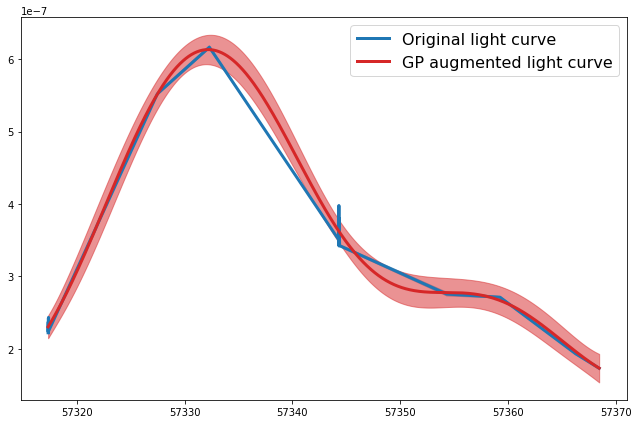

In [20]:
x = curve_r.x
y = curve_r.y
err = curve_r.err

plt.figure(figsize=(9, 6))
plt.plot(x, y, color='C0', linewidth=3, label='Original light curve')
plt.fill_between(x, y-err, y+err, alpha=0.5)

x = curve_r_gp.x
y = curve_r_gp.y
err = curve_r_gp.err
plt.plot(x, y, color='C3', linewidth=3, label='GP augmented light curve')
plt.fill_between(x, y-err, y+err, alpha=0.5, color='C3')


plt.legend(loc='best', fontsize=16)
plt.tight_layout()
plt.show()

In [21]:
%%time
good_data['curve_r_gp'] = good_data.apply(gp_augmentation, axis=1)

CPU times: user 1min 50s, sys: 7.56 s, total: 1min 57s
Wall time: 1min 29s


## Preprocessing

In [22]:
def normalization_gp(row):
    y = row.curve_r_gp.y / row.curve_r_gp.y.max()
    return y

good_data['y_normed_gp'] = good_data.apply(normalization_gp, axis=1)

In [23]:
def shifting_gp(row):
    x = row.curve_r_gp.x - row.curve_r_gp.x[row.y_normed_gp.argmax()]
    return x

good_data['x_shifted_gp'] = good_data.apply(shifting_gp, axis=1)

In [24]:
n_bins = 16

def get_bins_gp(row):
    return binarization(row.x_shifted_gp, row.y_normed_gp, n=n_bins, x_ranges=[-50, 100])

good_data['binarized_gp'] = good_data.apply(get_bins_gp, axis=1)

In [25]:
def interpolate_gp(row):
    return interpolation(np.arange(len(row.binarized_gp)), row.binarized_gp)

good_data['interpolated_gp'] = good_data.apply(interpolate_gp, axis=1)

In [26]:
def generate_features_gp(row):
    return rolling_ratio(row.interpolated_gp)

good_data['rolling_ratios_gp'] = good_data.apply(generate_features_gp, axis=1)

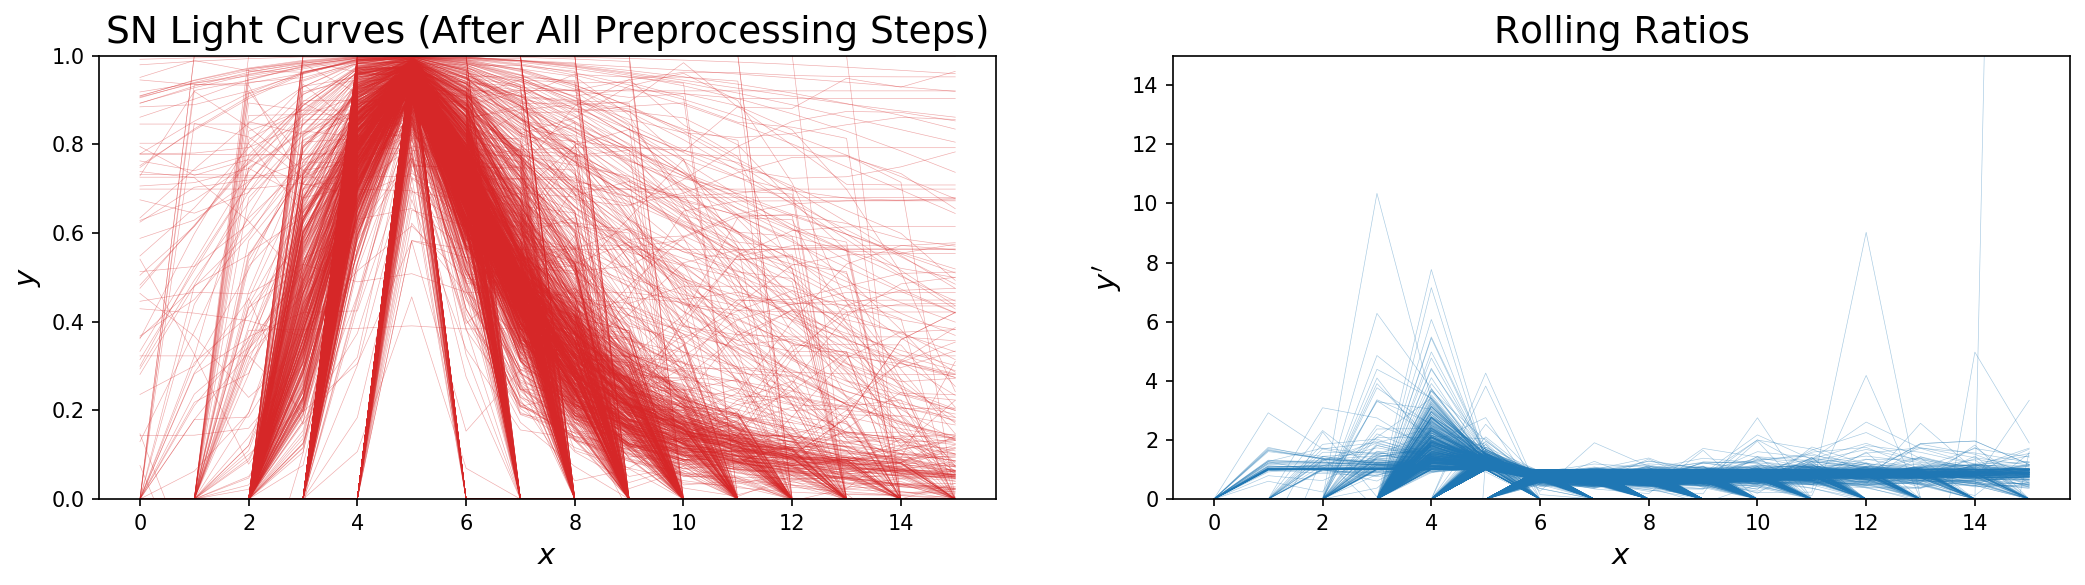

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4), dpi=150)

for i in range(good_data.shape[0]):
    y = good_data.loc[i, 'interpolated_gp']
    x = np.linspace(0, n_bins-1, n_bins)
    ax[0].plot(x, y, alpha=0.4, color='C3', linewidth=0.3)
    
for i in range(good_data.shape[0]):
    y = good_data.loc[i, 'rolling_ratios_gp']
    x = np.linspace(0, n_bins-1, n_bins)
    ax[1].plot(x, y, alpha=0.4, color='C0', linewidth=0.3)
    
ax[0].set_title('SN Light Curves (After All Preprocessing Steps)',  fontsize=18)
ax[1].set_title('Rolling Ratios', fontsize=18)
ax[1].set_ylim(0, n_bins-1)
ax[0].set_ylim(0, 1)

ax[0].set_xlabel('$x$', fontsize=14)
ax[0].set_ylabel('$y$', fontsize=14)
ax[1].set_xlabel('$x$', fontsize=14)
ax[1].set_ylabel("$y'$", fontsize=14)
    
plt.tight_layout()
plt.show()

In [28]:
good_data.head()

,index,sn_name,type,size_r,curve_r,spec_class,rms,rms_for_pval,is_ia,pval,curve_r_gp,y_normed_gp,x_shifted_gp,binarized_gp,interpolated_gp,rolling_ratios_gp
0,0,ASASSN-13ax,Dwarf Nova,122,"[[56477.4482, nan, 1.8373842952834476e-06, 7.4...",0,9186.448800,1.111560e+06,0,0.0,"[[56477.4482, nan, 1.8489306190250163e-06, 7.6...","[1.0, 0.9954499553768814, 0.9909012101049555, ...","[0.0, 0.03294644644483924, 0.06589289288967848...","[0, 0, 0, 0, 0, 0.6752008739494583, 0.33792440...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.6752008739494584, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5004798135998..."
1,1,ASASSN-13cu,Ia,4,"[[56531.4793028785, nan, 1.9052852266272632e-0...",0,2674.142946,8.022429e+03,1,0.0,"[[56531.4793028785, nan, 1.906361132369015e-07...","[1.0, 0.9999976200855275, 0.9999856542408163, ...","[0.0, 0.08784868365182774, 0.17569736730365548...","[0, 0, 0, 0, 0, 0.9920931739485523, 0.92870256...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.9920931739485522, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9361041805899..."
2,4,ASASSN-14ae,TDE,45,"[[56684.1203, nan, 3.8508801287880484e-07, 8.2...",1,433.613743,1.907900e+04,0,0.0,"[[56684.1203, nan, 3.216038024796768e-07, 4.71...","[1.0, 0.9995893409813769, 0.9991763433395633, ...","[0.0, 0.07084564564866014, 0.14169129129004432...","[0, 0, 0, 0, 0, 0.9790378208338455, 0.91026326...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.9790378208338456, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9297529124169..."
3,6,ASASSN-14bb,Ia,8,"[[56798.8868, nan, 8.312276860137896e-07, 3.52...",0,532.439311,3.727075e+03,1,0.0,"[[56798.8868, nan, 8.321664701429013e-07, 1.86...","[0.9849087885699158, 0.985158271918745, 0.9854...","[-2.9767937937940587, -2.949732032029715, -2.9...","[0, 0, 0, 0, 0, 0.9805008609587595, 0.80829752...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.9805008609587594, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8243720665465..."
4,7,ASASSN-14dq,II;IIb,97,"[[56850.09, nan, 4.988844874600117e-07, 5.9733...",0,4474.522320,4.295541e+05,0,0.0,"[[56850.09, nan, 4.855980344518189e-07, 8.4302...","[0.9798631691054228, 0.9833244634995866, 0.986...","[-3.7583553553558886, -3.4166866866871715, -3....","[0, 0, 0, 0, 0.9815938163025046, 0.98797714903...","[0.0, 0.0, 0.0, 0.0, 0.9815938163025046, 0.987...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0065030286683154, ..."


In [29]:
data = good_data.copy()

In [30]:
init_features = np.stack(data.interpolated_gp.values)
generated_features = np.stack(data.rolling_ratios_gp.values)
print('Length of the initial vector:', init_features[0].shape[0])
print('Length of the generated vector:', generated_features[0].shape[0])

Length of the initial vector: 16
Length of the generated vector: 16


In [31]:
features_df = pd.DataFrame(np.concatenate((init_features, generated_features), axis=1))
features_df.columns = ['x_' + str(i) for i in range(n_bins)] + ['d_' + str(i) for i in range(n_bins)]
features_df.head()

,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,...,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15
0,0.0,0.0,0.0,0.0,0.000000,0.675201,0.337924,0.155838,0.137063,0.000000,...,0.500480,0.461163,0.879519,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.0,0.0,0.0,0.0,0.000000,0.992093,0.928703,0.801389,0.670463,0.567568,...,0.936104,0.862912,0.836626,0.846531,0.847274,0.787595,0.655004,0.485386,0.463835,0.000000
2,0.0,0.0,0.0,0.0,0.000000,0.979038,0.910263,0.807330,0.700603,0.612297,...,0.929753,0.886920,0.867802,0.873956,0.910353,0.967589,1.020955,0.000000,0.000000,0.000000
3,0.0,0.0,0.0,0.0,0.000000,0.980501,0.808298,0.694667,0.000000,0.000000,...,0.824372,0.859420,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.0,0.0,0.0,0.0,0.981594,0.987977,0.889083,0.779849,0.722441,0.670320,...,0.899903,0.877139,0.926385,0.927855,0.918391,0.902520,0.914757,0.874373,0.657583,0.503363


In [32]:
data = pd.concat([data.reset_index(drop=True), features_df.reset_index(drop=True)], axis=1)

In [33]:
data.head()

,index,sn_name,type,size_r,curve_r,spec_class,rms,rms_for_pval,is_ia,pval,...,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15
0,0,ASASSN-13ax,Dwarf Nova,122,"[[56477.4482, nan, 1.8373842952834476e-06, 7.4...",0,9186.448800,1.111560e+06,0,0.0,...,0.500480,0.461163,0.879519,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,ASASSN-13cu,Ia,4,"[[56531.4793028785, nan, 1.9052852266272632e-0...",0,2674.142946,8.022429e+03,1,0.0,...,0.936104,0.862912,0.836626,0.846531,0.847274,0.787595,0.655004,0.485386,0.463835,0.000000
2,4,ASASSN-14ae,TDE,45,"[[56684.1203, nan, 3.8508801287880484e-07, 8.2...",1,433.613743,1.907900e+04,0,0.0,...,0.929753,0.886920,0.867802,0.873956,0.910353,0.967589,1.020955,0.000000,0.000000,0.000000
3,6,ASASSN-14bb,Ia,8,"[[56798.8868, nan, 8.312276860137896e-07, 3.52...",0,532.439311,3.727075e+03,1,0.0,...,0.824372,0.859420,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,7,ASASSN-14dq,II;IIb,97,"[[56850.09, nan, 4.988844874600117e-07, 5.9733...",0,4474.522320,4.295541e+05,0,0.0,...,0.899903,0.877139,0.926385,0.927855,0.918391,0.902520,0.914757,0.874373,0.657583,0.503363


In [34]:
X = data.loc[:, 'x_0':'d_'+str(n_bins-1)].values
y = data['is_ia'].values
indices = np.arange(data.shape[0])

## Models

### LogReg

In [35]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(penalty='l2',
                            random_state=42,
                            solver='lbfgs',
                            max_iter=1000)

predictions, test_indices = kfold(logreg, X, y)

In [36]:
data['logreg_pred'] = get_predictions(X, predictions, test_indices)

### RF

In [37]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=1000,
                            min_samples_split=10, 
                            min_samples_leaf=2, 
                            max_features='auto',
                            bootstrap=True, 
                            max_depth=10, 
                            n_jobs=4, 
                            random_state=25)

predictions, test_indices = kfold(rf, X, y)

In [38]:
data['rf_pred'] = get_predictions(X, predictions, test_indices)

### XGBoost

In [39]:
from xgboost import XGBClassifier

xgb = XGBClassifier(n_estimators=1000, 
                    learning_rate=0.02, 
                    max_depth=6, 
                    subsample=0.8, 
                    colsample=0.7, 
                    min_child_weight=1, 
                    n_jobs=3)

predictions, test_indices = kfold(xgb, X, y)

In [40]:
data['xgb_pred'] = get_predictions(X, predictions, test_indices)

### NN

In [41]:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.callbacks import History 
from keras.utils import plot_model, to_categorical
from keras.optimizers import SGD
import sklearn.metrics as metrics


nn = Sequential()
nn.add(Dense(32, activation='relu', input_dim=X.shape[1]))
nn.add(Dense(1, activation='sigmoid'))

nn.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

predictions, test_indices = kfold(nn, X, y, 'nn')

Using TensorFlow backend.


In [42]:
data['nn'] = get_predictions(X, predictions, test_indices)

## Evaluation

In [43]:
scores_dict = {}

for model_pred in data.loc[:, 'logreg_pred':].columns:
    y_pred = data[model_pred].values
    auc = roc_auc_score(data.is_ia, y_pred)
    acc = accuracy_score(data.is_ia, y_pred>=0.5)
    f1 = f1_score(data.is_ia, y_pred>=0.5)
    pr = precision_score(data.is_ia, y_pred>=0.5)
    rec = recall_score(data.is_ia, y_pred>=0.5)
    scores_dict[model_pred] = [auc, acc, f1, pr, rec]

In [44]:
scores_df = pd.DataFrame(scores_dict)
scores_df['score'] = ['AUC', 'Acc', 'F1-score', 'Precision', 'Recall']
scores_df.set_index('score')

,logreg_pred,rf_pred,xgb_pred,nn
score,,,,
AUC,0.803834,0.882985,0.880496,0.864844
Acc,0.849378,0.863785,0.859856,0.854617
F1-score,0.908658,0.915516,0.912007,0.910843
Precision,0.857571,0.881847,0.888622,0.868300
Recall,0.966216,0.951858,0.936655,0.957770


In [45]:
spec_scores_dict = {}

for model_pred in data.loc[:, 'logreg_pred':].columns:
    y_pred = data[data.spec_class == 1][model_pred].values
    auc = roc_auc_score(data[data.spec_class == 1].is_ia, y_pred)
    acc = accuracy_score(data[data.spec_class == 1].is_ia, y_pred>=0.5)
    f1 = f1_score(data[data.spec_class == 1].is_ia, y_pred>=0.5)
    pr = precision_score(data[data.spec_class == 1].is_ia, y_pred>=0.5)
    rec = recall_score(data[data.spec_class == 1].is_ia, y_pred>=0.5)
    spec_scores_dict[model_pred] = [auc, acc, f1, pr, rec]

In [46]:
spec_scores_df = pd.DataFrame(spec_scores_dict)
spec_scores_df['score'] = ['AUC', 'Acc', 'F1-score', 'Precision', 'Recall']
spec_scores_df.set_index('score')

,logreg_pred,rf_pred,xgb_pred,nn
score,,,,
AUC,0.796324,0.927325,0.925846,0.879696
Acc,0.860417,0.897917,0.897917,0.866667
F1-score,0.919952,0.940171,0.939431,0.922330
Precision,0.865169,0.901639,0.911271,0.879630
Recall,0.982143,0.982143,0.969388,0.969388


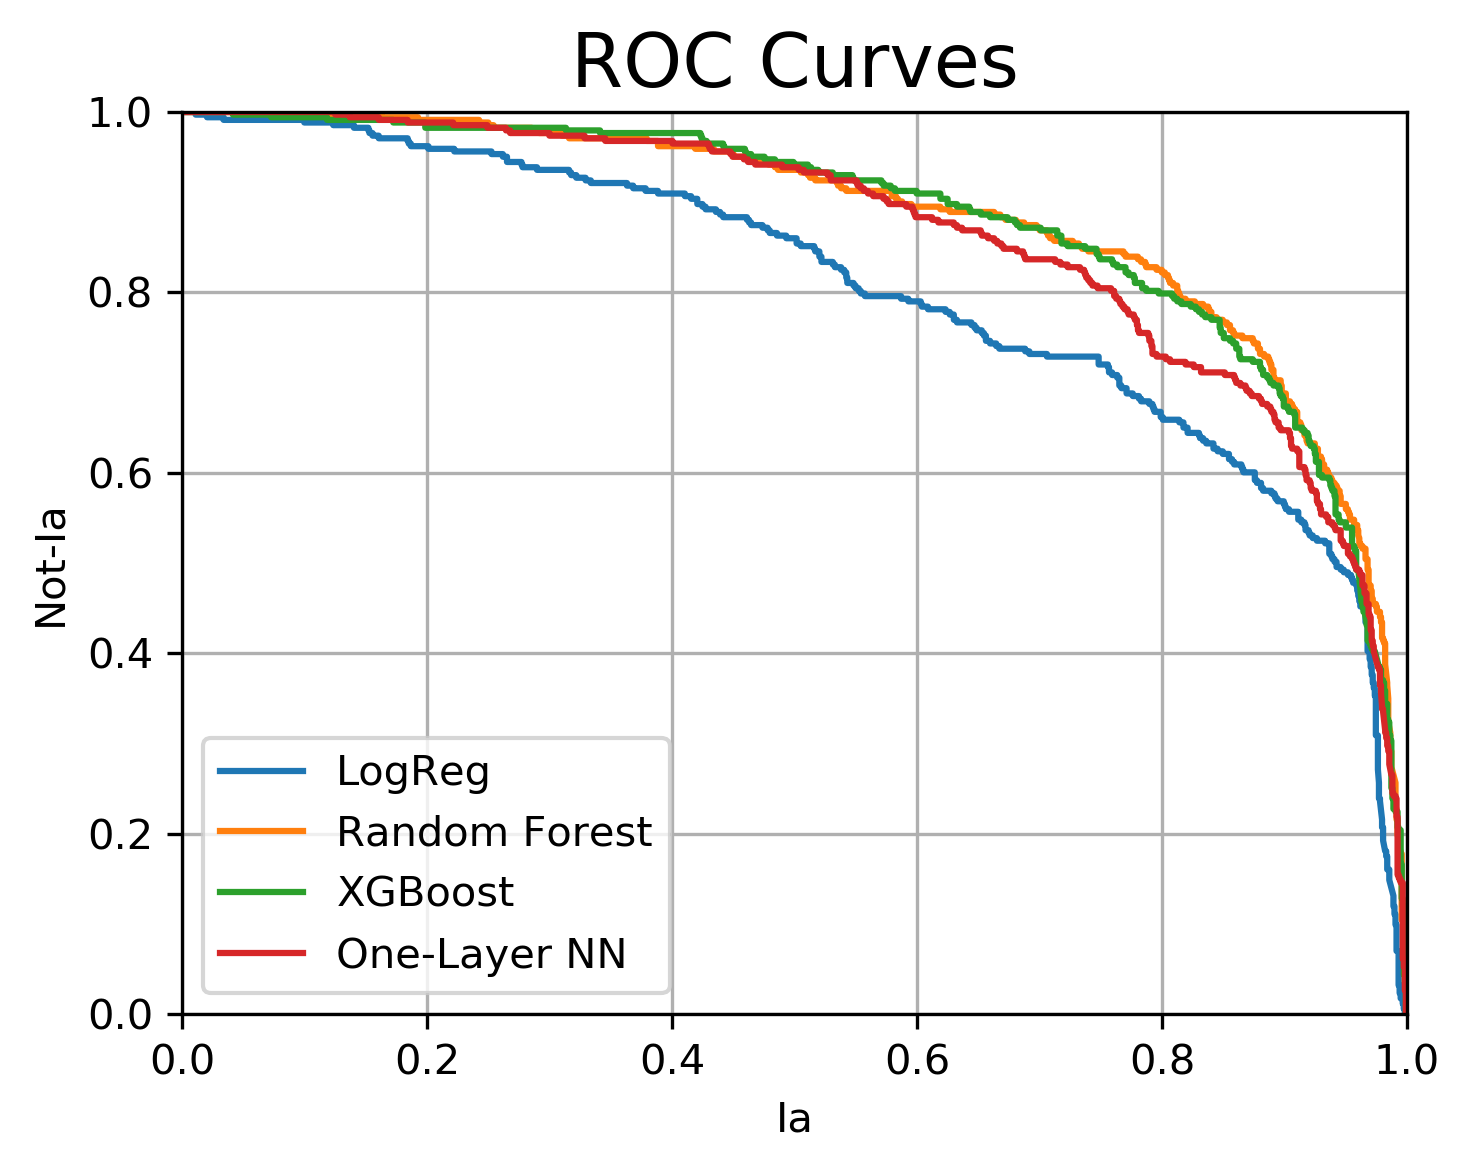

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4), dpi=300)

models = ['LogReg', 'Random Forest', 'XGBoost', 'One-Layer NN']

ax.set_xlabel('Ia')
ax.set_ylabel('Not-Ia')
ax.set_xlim(0., 1)
ax.set_ylim(0., 1)
ax.set_title('ROC Curves', fontsize=18)
ax.grid(b=0.1)

colors = ['C0', 'C1', 'C2', 'C3']

for i, model_pred in enumerate(data.loc[:, 'logreg_pred':].columns):
    y_pred = data[model_pred].values
    fpr, tpr, thresholds = roc_curve(data.is_ia, y_pred)
    ax.plot(tpr, 1-fpr, linewidth=1.5, label=models[i], color=colors[i])
    
ax.legend()
    
plt.tight_layout()
plt.show()

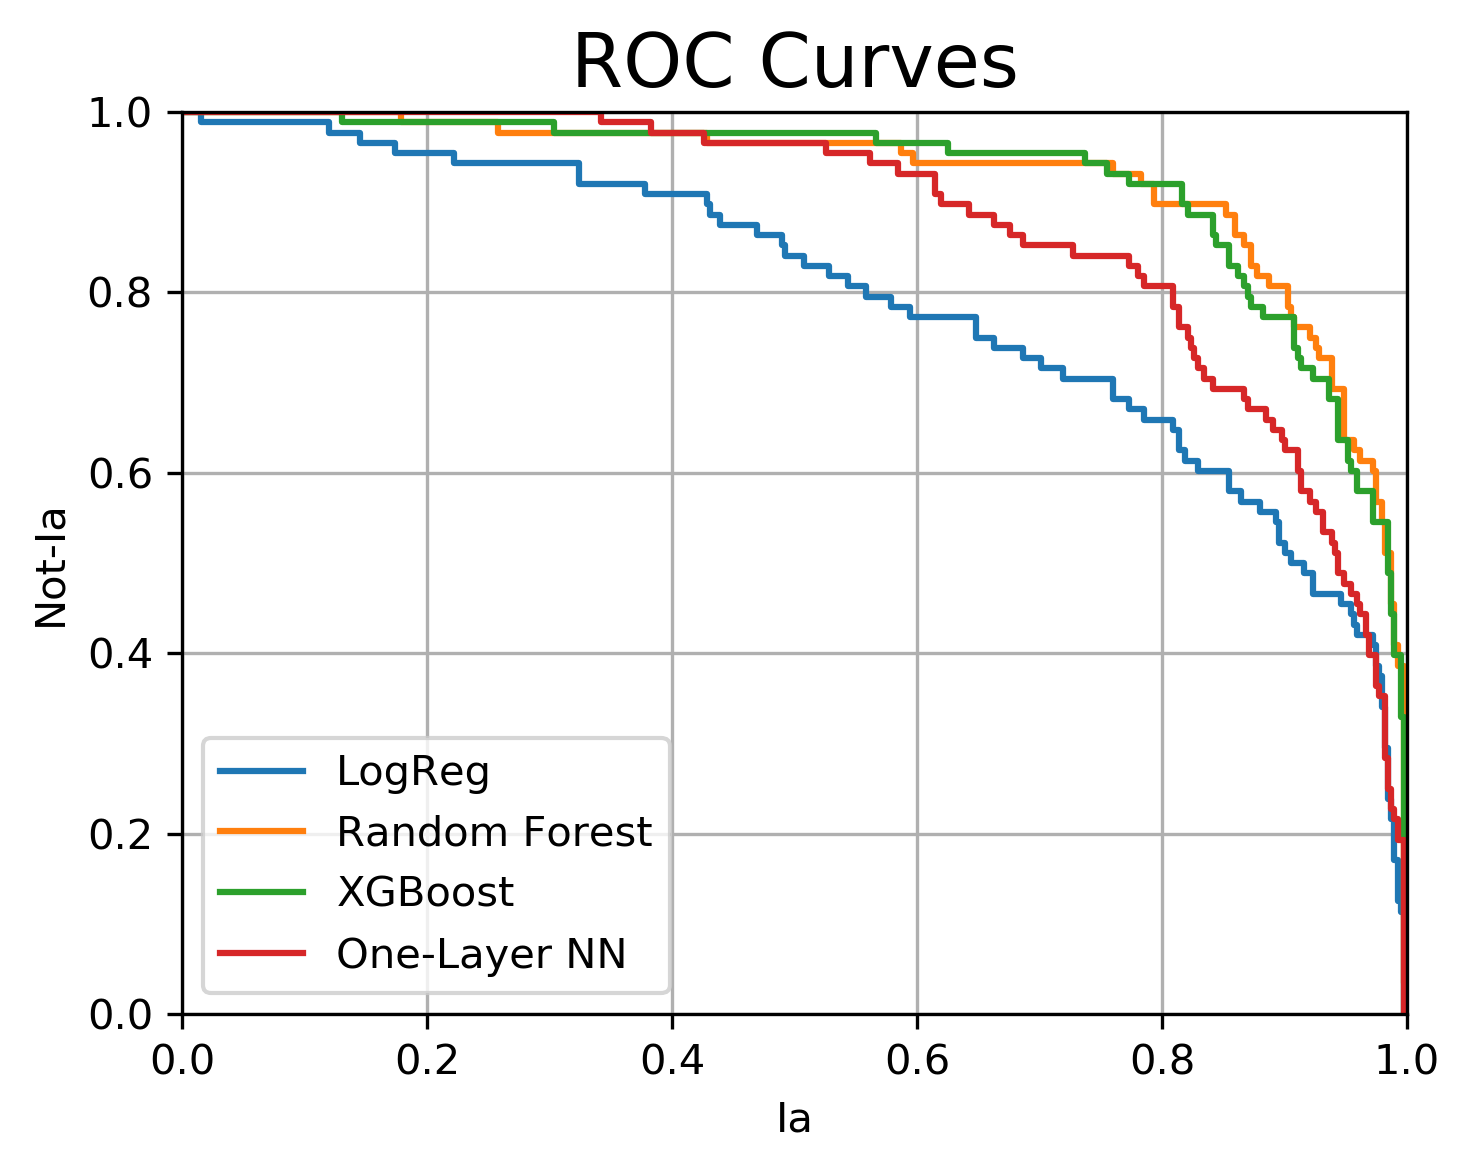

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4), dpi=300)

models = ['LogReg', 'Random Forest', 'XGBoost', 'One-Layer NN']

ax.set_xlabel('Ia')
ax.set_ylabel('Not-Ia')
ax.set_xlim(0., 1)
ax.set_ylim(0., 1)
ax.set_title('ROC Curves', fontsize=18)
ax.grid(b=0.1)

colors = ['C0', 'C1', 'C2', 'C3']

for i, model_pred in enumerate(data.loc[:, 'logreg_pred':].columns):
    y_pred = data[data.spec_class == 1][model_pred].values
    fpr, tpr, thresholds = roc_curve(data[data.spec_class == 1].is_ia, y_pred)
    ax.plot(tpr, 1-fpr, linewidth=1.5, label=models[i], color=colors[i])
    
ax.legend()
    
plt.tight_layout()
plt.show()

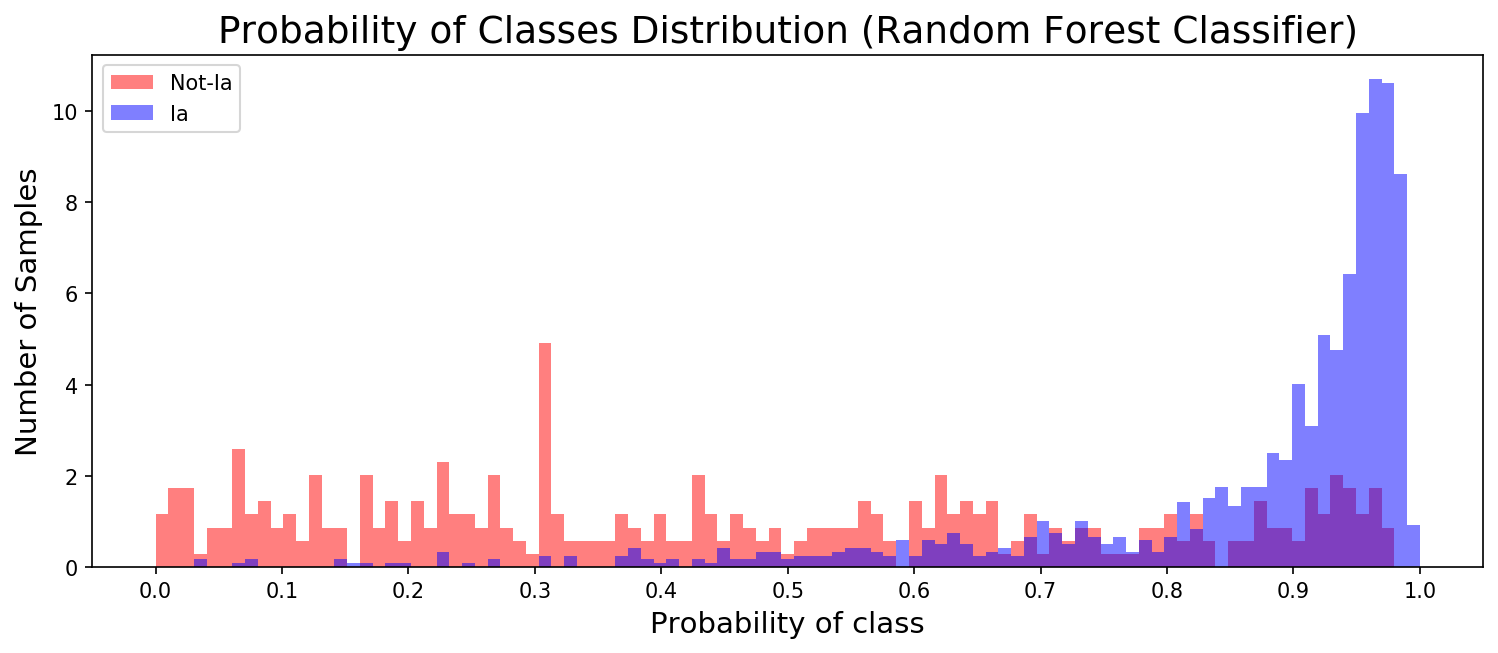

In [49]:
y_pred = data.rf_pred.values

fig, ax = plt.subplots(figsize=(10, 4), dpi=150)

plt.tight_layout()

ax.set_title('Probability of Classes Distribution (Random Forest Classifier)', fontsize=18)
ax.set_xticks(np.linspace(0, 1, 11))
ax.set_xlabel('Probability of class', fontsize=14)
ax.set_ylabel('Number of Samples', fontsize=14)
ax.hist(y_pred[data.is_ia.values == 0].reshape(-1, 1), 
        bins=np.linspace(0, 1, 100), 
        density=True, 
        label='Not-Ia', 
        color='r', alpha=0.5)
ax.hist(y_pred[data.is_ia.values == 1].reshape(-1, 1), 
        bins=np.linspace(0, 1, 100), 
        density=True, 
        label='Ia', 
        color='b', 
        alpha=0.5)
ax.legend(loc='best')

plt.show()

In [50]:
data['claimed_type'] = data.type.apply(lambda x: x.split(';')[0])

# Features

In [51]:
#!pip install feets
#!pip install tsfresh

In [52]:
import feets
from scipy import stats

In [53]:
%%time

import warnings
warnings.filterwarnings("ignore")

f = ['Amplitude', 'Beyond1Std', 'Gskew', 'Mean', 'Q31', 'Std', 
     'Eta_e', 'MaxSlope', 'LinearTrend', 'StetsonK', 
     'Meanvariance', 'MedianAbsDev', 'MedianBRP', 'PercentDifferenceFluxPercentile', 'FluxPercentileRatioMid35', 'FluxPercentileRatioMid80', 'Autocor_length']

X = []
y = []

for i in range(len(data)):
    
    curve = data.loc[i].curve_r_gp

    fs = feets.FeatureSpace(data=['time', 'magnitude', 'error'], only=f)
    _, values = fs.extract(time=curve.x, magnitude=curve.y, error=curve.err)
    
    X.append(values)
    y.append(data.loc[i].is_ia)

X = np.array(X)
y = np.array(y)

CPU times: user 10.3 s, sys: 127 ms, total: 10.4 s
Wall time: 13.6 s


In [54]:
X = np.nan_to_num(X)

indices = np.arange(X.shape[0])

## Models

### LogReg

In [55]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(penalty='l2',
                            random_state=42,
                            solver='lbfgs',
                            max_iter=1000)

predictions, test_indices = kfold(logreg, X, y)

In [56]:
data['logreg_pred'] = get_predictions(X, predictions, test_indices)

### RF

In [57]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=1000,
                            min_samples_split=10, 
                            min_samples_leaf=2, 
                            max_features='auto',
                            bootstrap=True, 
                            max_depth=10, 
                            n_jobs=4, 
                            random_state=25)

predictions, test_indices = kfold(rf, X, y)

In [58]:
data['rf_pred'] = get_predictions(X, predictions, test_indices)

### XGBoost

In [59]:
from xgboost import XGBClassifier

xgb = XGBClassifier(n_estimators=1000, 
                    learning_rate=0.02, 
                    max_depth=6, 
                    subsample=0.8, 
                    colsample=0.7, 
                    min_child_weight=1, 
                    n_jobs=3)

predictions, test_indices = kfold(xgb, X, y)

In [60]:
data['xgb_pred'] = get_predictions(X, predictions, test_indices)

### NN

In [61]:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.callbacks import History 
from keras.utils import plot_model, to_categorical
from keras.optimizers import SGD
import sklearn.metrics as metrics


nn = Sequential()
nn.add(Dense(32, activation='relu', input_dim=X.shape[1]))
nn.add(Dense(1, activation='sigmoid'))

nn.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

predictions, test_indices = kfold(nn, X, y, 'nn')

In [62]:
data['nn'] = get_predictions(X, predictions, test_indices)

## Evaluation

In [63]:
scores_dict = {}

for model_pred in ['logreg_pred', 'rf_pred', 'xgb_pred', 'nn']:
    y_pred = data[model_pred].values
    auc = roc_auc_score(data.is_ia, y_pred)
    acc = accuracy_score(data.is_ia, y_pred>=0.5)
    f1 = f1_score(data.is_ia, y_pred>=0.5)
    pr = precision_score(data.is_ia, y_pred>=0.5)
    rec = recall_score(data.is_ia, y_pred>=0.5)
    scores_dict[model_pred] = [auc, acc, f1, pr, rec]

In [64]:
scores_df = pd.DataFrame(scores_dict)
scores_df['score'] = ['AUC', 'Acc', 'F1-score', 'Precision', 'Recall']
scores_df.set_index('score')

,logreg_pred,rf_pred,xgb_pred,nn
score,,,,
AUC,0.622863,0.728457,0.888314,0.562468
Acc,0.781925,0.799607,0.844794,0.786509
F1-score,0.875607,0.882669,0.902749,0.878539
Precision,0.784997,0.808287,0.877893,0.786000
Recall,0.989865,0.972128,0.929054,0.995777


In [65]:
spec_scores_dict = {}

for model_pred in ['logreg_pred', 'rf_pred', 'xgb_pred', 'nn']:
    y_pred = data[data.spec_class == 1][model_pred].values
    auc = roc_auc_score(data[data.spec_class == 1].is_ia, y_pred)
    acc = accuracy_score(data[data.spec_class == 1].is_ia, y_pred>=0.5)
    f1 = f1_score(data[data.spec_class == 1].is_ia, y_pred>=0.5)
    pr = precision_score(data[data.spec_class == 1].is_ia, y_pred>=0.5)
    rec = recall_score(data[data.spec_class == 1].is_ia, y_pred>=0.5)
    spec_scores_dict[model_pred] = [auc, acc, f1, pr, rec]

In [66]:
spec_scores_df = pd.DataFrame(spec_scores_dict)
spec_scores_df['score'] = ['AUC', 'Acc', 'F1-score', 'Precision', 'Recall']
spec_scores_df.set_index('score')

,logreg_pred,rf_pred,xgb_pred,nn
score,,,,
AUC,0.597779,0.739651,0.906859,0.608795
Acc,0.818750,0.818750,0.877083,0.820833
F1-score,0.900115,0.897767,0.926890,0.900922
Precision,0.818372,0.832244,0.901205,0.821429
Recall,1.000000,0.974490,0.954082,0.997449


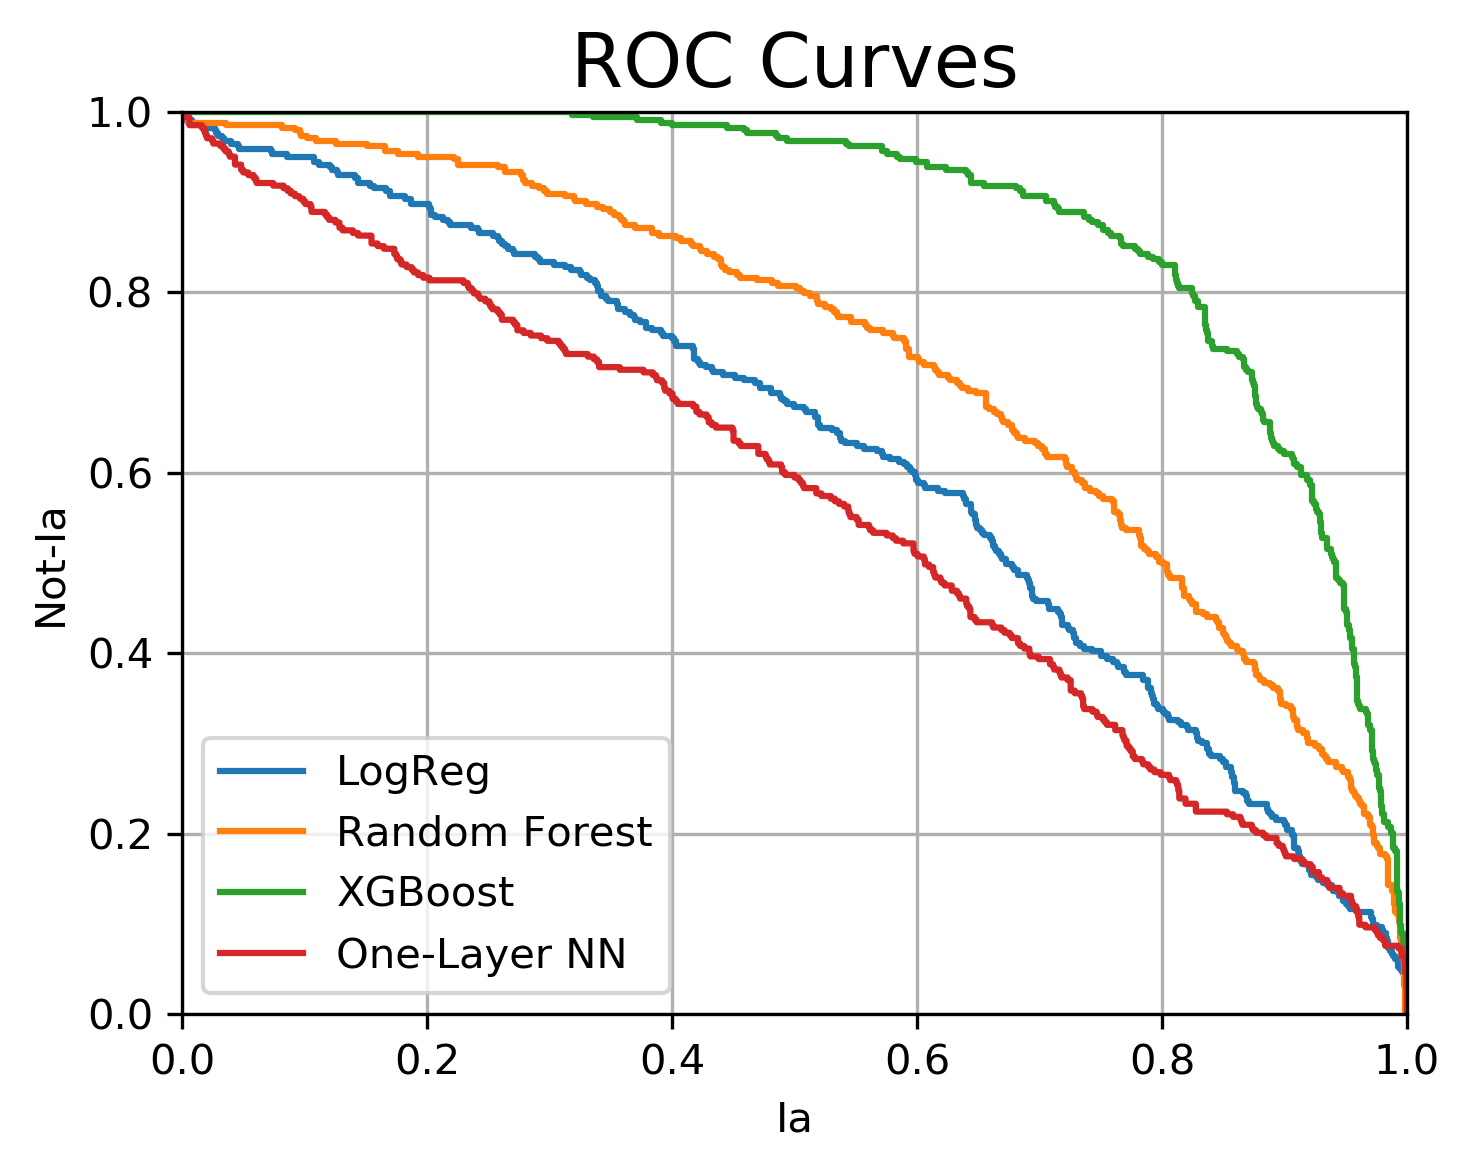

In [67]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4), dpi=300)

models = ['LogReg', 'Random Forest', 'XGBoost', 'One-Layer NN']

ax.set_xlabel('Ia')
ax.set_ylabel('Not-Ia')
ax.set_xlim(0., 1)
ax.set_ylim(0., 1)
ax.set_title('ROC Curves', fontsize=18)
ax.grid(b=0.1)

colors = ['C0', 'C1', 'C2', 'C3']

for i, model_pred in enumerate(['logreg_pred', 'rf_pred', 'xgb_pred', 'nn']):
    y_pred = data[model_pred].values
    fpr, tpr, thresholds = roc_curve(data.is_ia, y_pred)
    ax.plot(tpr, 1-fpr, linewidth=1.5, label=models[i], color=colors[i])
    
ax.legend()
    
plt.tight_layout()
plt.show()

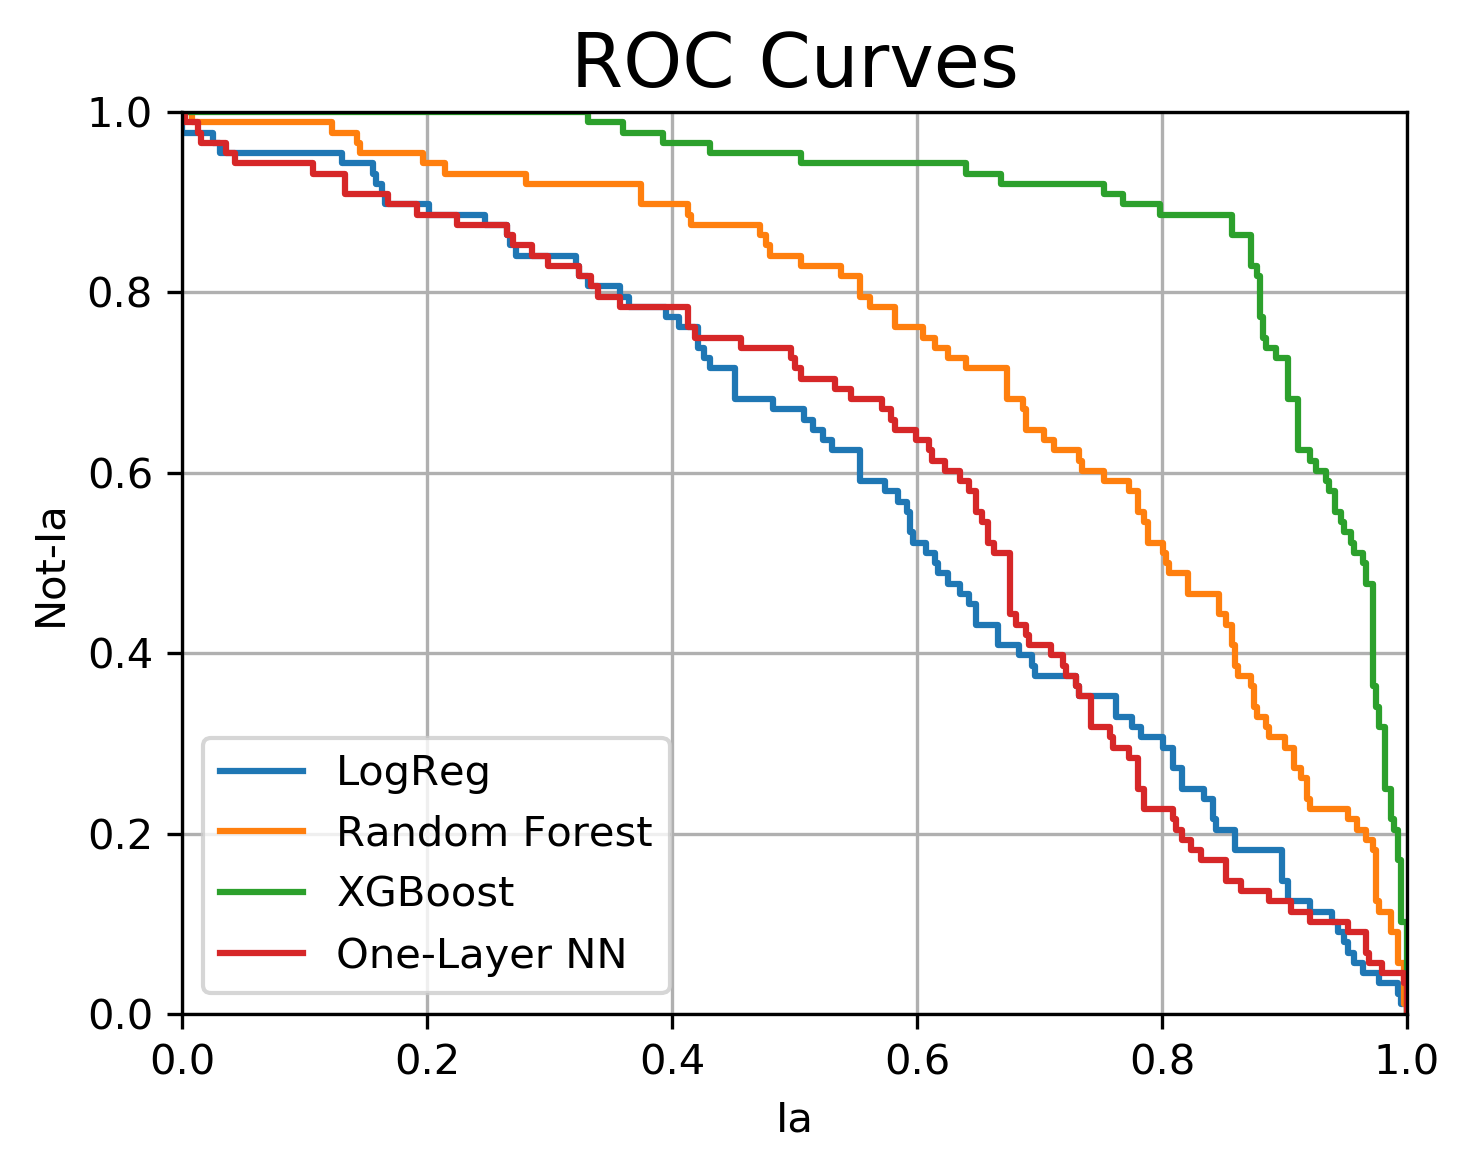

In [68]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4), dpi=300)

models = ['LogReg', 'Random Forest', 'XGBoost', 'One-Layer NN']

ax.set_xlabel('Ia')
ax.set_ylabel('Not-Ia')
ax.set_xlim(0., 1)
ax.set_ylim(0., 1)
ax.set_title('ROC Curves', fontsize=18)
ax.grid(b=0.1)

colors = ['C0', 'C1', 'C2', 'C3']

for i, model_pred in enumerate(['logreg_pred', 'rf_pred', 'xgb_pred', 'nn']):
    y_pred = data[data.spec_class == 1][model_pred].values
    fpr, tpr, thresholds = roc_curve(data[data.spec_class == 1].is_ia, y_pred)
    ax.plot(tpr, 1-fpr, linewidth=1.5, label=models[i], color=colors[i])
    
ax.legend()
    
plt.tight_layout()
plt.show()

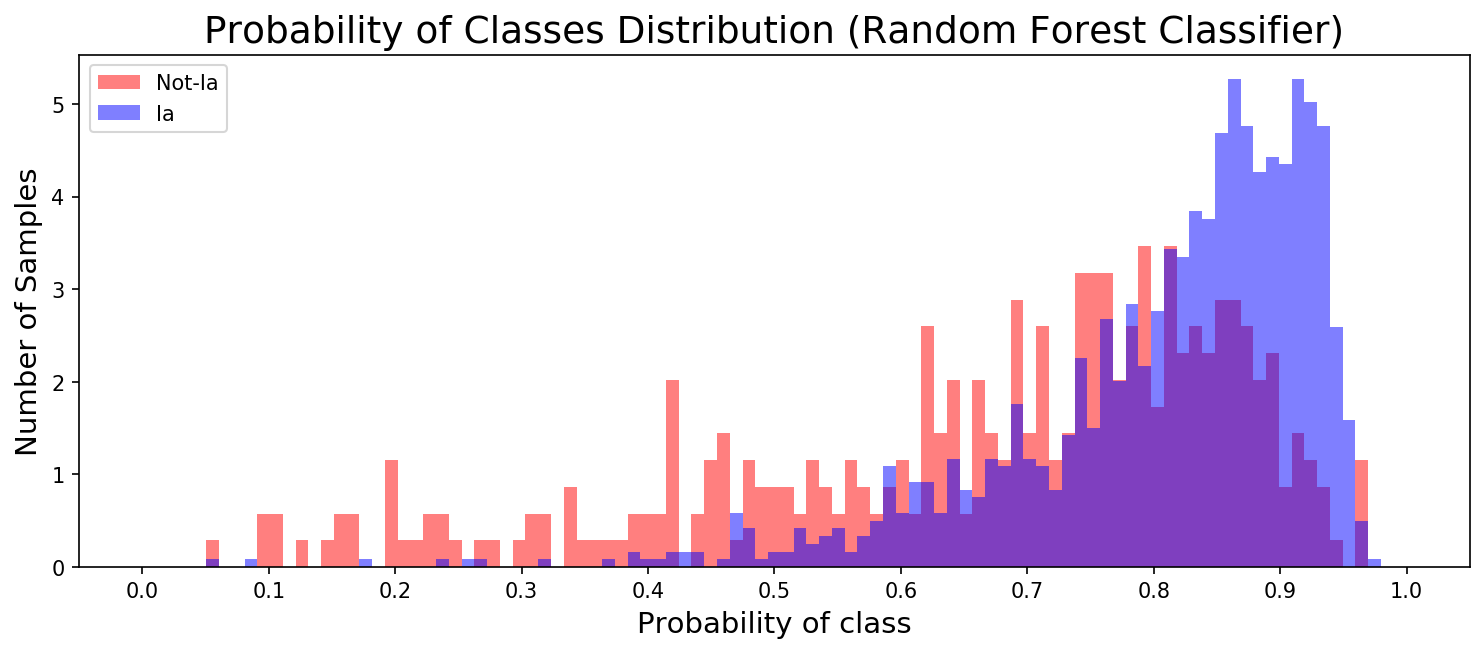

In [69]:
y_pred = data.rf_pred.values

fig, ax = plt.subplots(figsize=(10, 4), dpi=150)

plt.tight_layout()

ax.set_title('Probability of Classes Distribution (Random Forest Classifier)', fontsize=18)
ax.set_xticks(np.linspace(0, 1, 11))
ax.set_xlabel('Probability of class', fontsize=14)
ax.set_ylabel('Number of Samples', fontsize=14)
ax.hist(y_pred[data.is_ia.values == 0].reshape(-1, 1), 
        bins=np.linspace(0, 1, 100), 
        density=True, 
        label='Not-Ia', 
        color='r', alpha=0.5)
ax.hist(y_pred[data.is_ia.values == 1].reshape(-1, 1), 
        bins=np.linspace(0, 1, 100), 
        density=True, 
        label='Ia', 
        color='b', 
        alpha=0.5)
ax.legend(loc='best')

plt.show()